In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
from statistics import mean
from random import choice
%matplotlib inline
import matplotlib.pyplot as plt
import glob
from gendis.genetic import GeneticExtractor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tools.data_extraction import DataExtractor
from tools.trajectory_generator import TrajectoryGenerator
from tools.utils import standardize_data, print_genetic_param, print_settings, set_movements, angle_diff,scale_down, get_distance
from tools.experiments import Experiments

np.random.seed(1337)  # Random seed for reproducibility

tr_gen_options = {"samples": 25,
                  "freq": 3,
                  "reset_data": True}
dt_gen_options = {"n_test": 150}

train_test_options = {"split": 25}

df_csv_options = {"ts_class": "Bearing"}

gen_options = {"population_size": 20,
               "iterations": 20,
               "verbose": True,
               "normed": True,
               "add_noise_prob": 0.0,
               "add_shapelet_prob": 0.3,
               "wait": 10,
               "plot": True,
               "remove_shapelet_prob": 0.3,
               "crossover_prob": 0.66,
               "n_jobs": 4}

settings = {"trajectory_generator_options": tr_gen_options,
            "data_generation_options": dt_gen_options,
            "train_test_options":train_test_options,
            "define_csvs_option": df_csv_options,
            "genetic_options": gen_options}

tr_gen_options = settings["trajectory_generator_options"]
dt_gen_options = settings["data_generation_options"]
df_csvs_options = settings["define_csvs_option"]
train_test_options = settings["train_test_options"]
genetic_options = settings["genetic_options"]

if len(glob.glob('models')) == 0 :
    path = "models"
    try:
        os.mkdir(path)
    except OSError:  
        print ("Creation of the directory %s failed" % path)
    else:  
        print ("Successfully created the directory %s " % path)
else:
    files = glob.glob("models/*")
    for x in files:
        os.remove(x)



In [2]:
movement_list = ["step_up_left","step_up_right",
                 "spiral_movement_right","spiral_movement_left",
                 "expanding_square_right","expanding_square_left",
                 "creeping_line_left","creeping_line_right",
                 "sector_pattern_left","sector_pattern_right"]
all_movements = []
for x in movement_list:
    first_movement = [x]
    second_movement = ['random']
    movements = {'first_movement': first_movement,'second_movement': second_movement}
    all_movements.append(movements)


2019-05-24 01:47:53.168 | INFO     | tools.trajectory_generator:data_generation:623 - 
 Starting the generator with attributes: 
Original latitude: 37.295493
Original longitude: 23.824322
Initial bearing: 90
Initial speed: 10
Number of samples: 25
Starting time of measurements: 2015-02-01 12:00:00
With initial frequency of collected data: 3 min
and hard reset of data: True
2019-05-24 01:47:53.171 | INFO     | tools.trajectory_generator:data_generation:626 - Create directory 'generator_data' 
2019-05-24 01:47:53.173 | INFO     | tools.trajectory_generator:data_generation:632 - now creating data for movement: step_up_left
2019-05-24 01:48:05.505 | INFO     | tools.trajectory_generator:data_generation:637 - now creating data for movement: random
2019-05-24 01:48:36.129 | SUCCESS  | tools.trajectory_generator:data_generation:670 - Done with generator
2019-05-24 01:48:36.131 | INFO     | tools.data_extraction:read_datasets:22 - Reading the data files
2019-05-24 01:48:36.890 | SUCCESS  | too

The train samples length is:6000
The test samples length is:1500

standardized train and test data



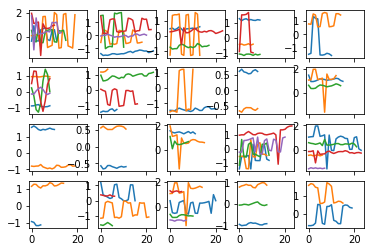

it		avg		std		max		time
1		-0.5837		0.046		-0.432234	10.0
2		-0.5173		0.078		-0.364114	7.7035
3		-0.4274		0.083		-0.259897	11.6623
4		-0.3354		0.07		-0.250787	14.2972
5		-0.2995		0.06		-0.250787	15.2658
6		-0.2735		0.03		-0.23392	17.5947
7		-0.2464		0.014		-0.223494	12.9279
8		-0.2277		0.02		-0.203522	18.4957
9		-0.2207		0.018		-0.201043	24.1437
10		-0.2033		0.01		-0.191107	19.0882
11		-0.1831		0.007		-0.173578	26.1438
12		-0.1703		0.007		-0.163143	27.206
13		-0.1656		0.005		-0.159907	18.8448
14		-0.152		0.013		-0.133743	25.9522
15		-0.1467		0.012		-0.127238	27.1498
16		-0.1406		0.023		-0.105346	27.1288
17		-0.1328		0.023		-0.105346	29.2598
18		-0.1243		0.014		-0.105346	30.1103
19		-0.1161		0.012		-0.099944	28.3081


2019-05-24 01:56:29.091 | INFO     | tools.trajectory_generator:data_generation:623 - 
 Starting the generator with attributes: 
Original latitude: 37.295493
Original longitude: 23.824322
Initial bearing: 90
Initial speed: 10
Number of samples: 25
Starting time of measurements: 2015-02-01 12:00:00
With initial frequency of collected data: 3 min
and hard reset of data: True
2019-05-24 01:56:29.093 | INFO     | tools.trajectory_generator:data_generation:626 - Create directory 'generator_data' 
2019-05-24 01:56:29.099 | INFO     | tools.trajectory_generator:data_generation:632 - now creating data for movement: step_up_right


20		-0.1124		0.01		-0.099486	29.6412


2019-05-24 01:56:41.577 | INFO     | tools.trajectory_generator:data_generation:637 - now creating data for movement: random
2019-05-24 01:57:13.003 | SUCCESS  | tools.trajectory_generator:data_generation:670 - Done with generator
2019-05-24 01:57:13.005 | INFO     | tools.data_extraction:read_datasets:22 - Reading the data files
2019-05-24 01:57:13.715 | SUCCESS  | tools.data_extraction:read_datasets:51 - Done reading files
2019-05-24 01:57:14.712 | INFO     | tools.data_extraction:define_csv:76 - Creating x_train.csv--y_train.csv and x_test.csv--y_test.csv 
2019-05-24 01:57:14.741 | SUCCESS  | tools.data_extraction:define_csv:101 - Done with train.csv
2019-05-24 01:57:14.750 | INFO     | tools.data_extraction:define_csv:122 - Done with test.csv
2019-05-24 01:57:14.753 | INFO     | tools.data_extraction:load_datasets:129 - Loading the csv files to the appropriate train and test arrays(nparrays)
2019-05-24 01:57:14.771 | SUCCESS  | tools.data_extraction:load_datasets:134 - Done


The train samples length is:6000
The test samples length is:1500

standardized train and test data



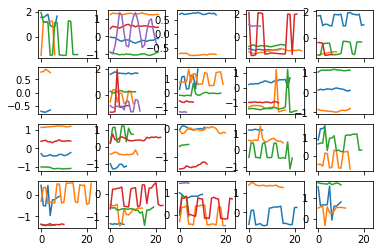

it		avg		std		max		time
1		-0.4251		0.118		-0.275507	11.8858
2		-0.3301		0.08		-0.258809	8.7157
3		-0.2998		0.041		-0.258809	13.8115
4		-0.272		0.024		-0.23796	12.8265
5		-0.252		0.034		-0.197979	17.728
6		-0.2378		0.042		-0.177619	15.6505
7		-0.1896		0.04		-0.127994	17.6186
8		-0.1691		0.047		-0.113557	22.386
9		-0.1373		0.017		-0.113557	29.9215
10		-0.1304		0.01		-0.113557	24.6508
11		-0.1242		0.01		-0.107499	27.0887
12		-0.1133		0.007		-0.10605	29.2108
13		-0.1069		0.004		-0.102713	22.5421
14		-0.1063		0.004		-0.102249	34.3346
15		-0.1044		0.004		-0.099584	34.2818
16		-0.1013		0.004		-0.095059	35.1094
17		-0.094		0.013		-0.071641	36.2803
18		-0.0861		0.013		-0.071641	36.0637
19		-0.0848		0.014		-0.069	45.7796


2019-05-24 02:06:46.408 | INFO     | tools.trajectory_generator:data_generation:623 - 
 Starting the generator with attributes: 
Original latitude: 37.295493
Original longitude: 23.824322
Initial bearing: 90
Initial speed: 10
Number of samples: 25
Starting time of measurements: 2015-02-01 12:00:00
With initial frequency of collected data: 3 min
and hard reset of data: True
2019-05-24 02:06:46.410 | INFO     | tools.trajectory_generator:data_generation:626 - Create directory 'generator_data' 
2019-05-24 02:06:46.413 | INFO     | tools.trajectory_generator:data_generation:632 - now creating data for movement: spiral_movement_right


20		-0.0889		0.012		-0.069	50.308


2019-05-24 02:07:20.944 | INFO     | tools.trajectory_generator:data_generation:637 - now creating data for movement: random
2019-05-24 02:07:52.636 | SUCCESS  | tools.trajectory_generator:data_generation:670 - Done with generator
2019-05-24 02:07:52.638 | INFO     | tools.data_extraction:read_datasets:22 - Reading the data files
2019-05-24 02:07:53.410 | SUCCESS  | tools.data_extraction:read_datasets:51 - Done reading files
2019-05-24 02:07:54.557 | INFO     | tools.data_extraction:define_csv:76 - Creating x_train.csv--y_train.csv and x_test.csv--y_test.csv 
2019-05-24 02:07:54.586 | SUCCESS  | tools.data_extraction:define_csv:101 - Done with train.csv
2019-05-24 02:07:54.596 | INFO     | tools.data_extraction:define_csv:122 - Done with test.csv
2019-05-24 02:07:54.597 | INFO     | tools.data_extraction:load_datasets:129 - Loading the csv files to the appropriate train and test arrays(nparrays)
2019-05-24 02:07:54.614 | SUCCESS  | tools.data_extraction:load_datasets:134 - Done


The train samples length is:6000
The test samples length is:1500

standardized train and test data



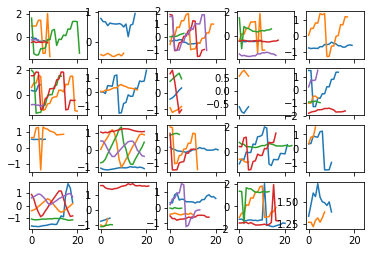

it		avg		std		max		time
1		-0.2409		0.084		-0.120253	13.3381
2		-0.1612		0.051		-0.056357	14.7828
3		-0.1308		0.042		-0.056357	14.9665
4		-0.1044		0.042		-0.047641	17.778
5		-0.074		0.026		-0.041831	23.4364
6		-0.0604		0.02		-0.041411	22.7473
7		-0.0502		0.021		-0.02814	24.4368
8		-0.0378		0.007		-0.02814	28.1797
9		-0.0365		0.005		-0.02814	28.3936
10		-0.0335		0.004		-0.02814	21.8535
11		-0.0301		0.002		-0.02814	28.0158
12		-0.032		0.004		-0.02814	25.933
13		-0.0294		0.003		-0.024533	28.0819
14		-0.0301		0.003		-0.024533	28.1228
15		-0.0274		0.005		-0.020288	33.9991
16		-0.0243		0.004		-0.020288	32.5032
17		-0.0228		0.003		-0.017789	31.9295
18		-0.0205		0.003		-0.017789	36.4345
19		-0.0219		0.002		-0.017789	31.1009


2019-05-24 02:17:10.397 | INFO     | tools.trajectory_generator:data_generation:623 - 
 Starting the generator with attributes: 
Original latitude: 37.295493
Original longitude: 23.824322
Initial bearing: 90
Initial speed: 10
Number of samples: 25
Starting time of measurements: 2015-02-01 12:00:00
With initial frequency of collected data: 3 min
and hard reset of data: True
2019-05-24 02:17:10.399 | INFO     | tools.trajectory_generator:data_generation:626 - Create directory 'generator_data' 
2019-05-24 02:17:10.405 | INFO     | tools.trajectory_generator:data_generation:632 - now creating data for movement: spiral_movement_left


20		-0.0203		0.002		-0.017447	30.0563


2019-05-24 02:17:44.372 | INFO     | tools.trajectory_generator:data_generation:637 - now creating data for movement: random
2019-05-24 02:18:15.787 | SUCCESS  | tools.trajectory_generator:data_generation:670 - Done with generator
2019-05-24 02:18:15.789 | INFO     | tools.data_extraction:read_datasets:22 - Reading the data files
2019-05-24 02:18:16.519 | SUCCESS  | tools.data_extraction:read_datasets:51 - Done reading files
2019-05-24 02:18:17.586 | INFO     | tools.data_extraction:define_csv:76 - Creating x_train.csv--y_train.csv and x_test.csv--y_test.csv 
2019-05-24 02:18:17.611 | SUCCESS  | tools.data_extraction:define_csv:101 - Done with train.csv
2019-05-24 02:18:17.622 | INFO     | tools.data_extraction:define_csv:122 - Done with test.csv
2019-05-24 02:18:17.624 | INFO     | tools.data_extraction:load_datasets:129 - Loading the csv files to the appropriate train and test arrays(nparrays)
2019-05-24 02:18:17.643 | SUCCESS  | tools.data_extraction:load_datasets:134 - Done


The train samples length is:6000
The test samples length is:1500

standardized train and test data



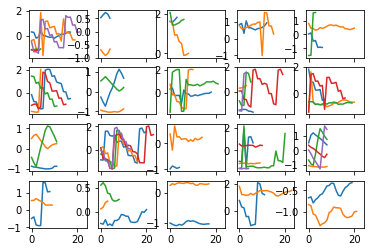

it		avg		std		max		time
1		-0.171		0.066		-0.119469	15.0138
2		-0.1439		0.049		-0.102706	12.9886
3		-0.1377		0.059		-0.05448	14.6174
4		-0.1151		0.048		-0.053449	15.7634
5		-0.1141		0.029		-0.053449	14.9968
6		-0.084		0.025		-0.053449	15.3246
7		-0.0768		0.02		-0.053449	20.6248
8		-0.0628		0.016		-0.050677	20.9779
9		-0.057		0.021		-0.034411	18.6079
10		-0.0664		0.036		-0.03118	20.3406
11		-0.0615		0.019		-0.029729	20.5353
12		-0.0451		0.019		-0.023853	20.5273
13		-0.0361		0.012		-0.023848	26.6553
14		-0.0271		0.004		-0.023848	23.5697
15		-0.0256		0.003		-0.022351	25.5985
16		-0.0221		0.002		-0.02042	28.6247
17		-0.0227		0.004		-0.015719	27.5836
18		-0.0201		0.003		-0.015719	26.6707
19		-0.0178		0.002		-0.015719	27.2527


2019-05-24 02:26:05.008 | INFO     | tools.trajectory_generator:data_generation:623 - 
 Starting the generator with attributes: 
Original latitude: 37.295493
Original longitude: 23.824322
Initial bearing: 90
Initial speed: 10
Number of samples: 25
Starting time of measurements: 2015-02-01 12:00:00
With initial frequency of collected data: 3 min
and hard reset of data: True
2019-05-24 02:26:05.011 | INFO     | tools.trajectory_generator:data_generation:626 - Create directory 'generator_data' 
2019-05-24 02:26:05.012 | INFO     | tools.trajectory_generator:data_generation:632 - now creating data for movement: expanding_square_right


20		-0.0165		0.001		-0.014111	33.2368


2019-05-24 02:26:11.178 | INFO     | tools.trajectory_generator:data_generation:637 - now creating data for movement: random
2019-05-24 02:26:42.777 | SUCCESS  | tools.trajectory_generator:data_generation:670 - Done with generator
2019-05-24 02:26:42.778 | INFO     | tools.data_extraction:read_datasets:22 - Reading the data files
2019-05-24 02:26:43.511 | SUCCESS  | tools.data_extraction:read_datasets:51 - Done reading files
2019-05-24 02:26:44.607 | INFO     | tools.data_extraction:define_csv:76 - Creating x_train.csv--y_train.csv and x_test.csv--y_test.csv 
2019-05-24 02:26:44.641 | SUCCESS  | tools.data_extraction:define_csv:101 - Done with train.csv
2019-05-24 02:26:44.654 | INFO     | tools.data_extraction:define_csv:122 - Done with test.csv
2019-05-24 02:26:44.655 | INFO     | tools.data_extraction:load_datasets:129 - Loading the csv files to the appropriate train and test arrays(nparrays)
2019-05-24 02:26:44.682 | SUCCESS  | tools.data_extraction:load_datasets:134 - Done


The train samples length is:6000
The test samples length is:1500

standardized train and test data



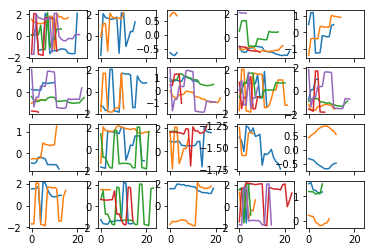

it		avg		std		max		time
1		-0.2659		0.128		-0.08819	11.7151
2		-0.2292		0.115		-0.080374	13.0339
3		-0.2038		0.105		-0.080374	14.3751
4		-0.1951		0.081		-0.080374	15.31
5		-0.1336		0.038		-0.080374	14.2117
6		-0.1182		0.037		-0.076091	19.3546
7		-0.1118		0.031		-0.076091	13.9996
8		-0.1156		0.02		-0.076091	16.7588
9		-0.106		0.022		-0.076091	16.9463
10		-0.1024		0.024		-0.076091	20.4005
11		-0.1187		0.028		-0.074481	24.0576
12		-0.1471		0.087		-0.074481	24.7085
13		-0.1107		0.033		-0.074481	22.0914
14		-0.1003		0.035		-0.065457	21.0189
15		-0.0913		0.021		-0.065457	19.3986
16		-0.0892		0.027		-0.057731	19.1172
17		-0.0815		0.021		-0.057731	20.8748
18		-0.0749		0.023		-0.048845	22.9494
19		-0.0801		0.034		-0.048845	20.2512


2019-05-24 02:33:35.914 | INFO     | tools.trajectory_generator:data_generation:623 - 
 Starting the generator with attributes: 
Original latitude: 37.295493
Original longitude: 23.824322
Initial bearing: 90
Initial speed: 10
Number of samples: 25
Starting time of measurements: 2015-02-01 12:00:00
With initial frequency of collected data: 3 min
and hard reset of data: True
2019-05-24 02:33:35.916 | INFO     | tools.trajectory_generator:data_generation:626 - Create directory 'generator_data' 
2019-05-24 02:33:35.919 | INFO     | tools.trajectory_generator:data_generation:632 - now creating data for movement: expanding_square_left


20		-0.086		0.038		-0.044158	19.7535


2019-05-24 02:33:39.085 | INFO     | tools.trajectory_generator:data_generation:637 - now creating data for movement: random
2019-05-24 02:34:10.572 | SUCCESS  | tools.trajectory_generator:data_generation:670 - Done with generator
2019-05-24 02:34:10.574 | INFO     | tools.data_extraction:read_datasets:22 - Reading the data files
2019-05-24 02:34:11.324 | SUCCESS  | tools.data_extraction:read_datasets:51 - Done reading files
2019-05-24 02:34:12.421 | INFO     | tools.data_extraction:define_csv:76 - Creating x_train.csv--y_train.csv and x_test.csv--y_test.csv 
2019-05-24 02:34:12.450 | SUCCESS  | tools.data_extraction:define_csv:101 - Done with train.csv
2019-05-24 02:34:12.462 | INFO     | tools.data_extraction:define_csv:122 - Done with test.csv
2019-05-24 02:34:12.463 | INFO     | tools.data_extraction:load_datasets:129 - Loading the csv files to the appropriate train and test arrays(nparrays)
2019-05-24 02:34:12.485 | SUCCESS  | tools.data_extraction:load_datasets:134 - Done


The train samples length is:6000
The test samples length is:1500

standardized train and test data



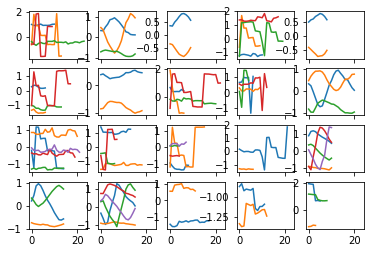

it		avg		std		max		time
1		-0.3148		0.127		-0.180628	12.4325
2		-0.251		0.054		-0.179428	8.7964
3		-0.2229		0.072		-0.179428	9.3273
4		-0.2075		0.051		-0.143892	11.4457
5		-0.1947		0.039		-0.143892	10.7574
6		-0.1948		0.037		-0.143892	13.9999
7		-0.1982		0.031		-0.143892	15.2629
8		-0.1736		0.038		-0.09681	17.1222
9		-0.1488		0.038		-0.09681	14.573
10		-0.1463		0.028		-0.09513	21.1277
11		-0.112		0.025		-0.094164	18.093
12		-0.1474		0.036		-0.094164	16.5596
13		-0.1358		0.031		-0.093403	18.7322
14		-0.1402		0.02		-0.093403	25.7797
15		-0.1185		0.022		-0.093403	18.7417
16		-0.1253		0.019		-0.093403	17.6467
17		-0.1187		0.023		-0.093403	14.9477
18		-0.1022		0.013		-0.075012	22.5124
19		-0.0967		0.012		-0.075012	29.3517


2019-05-24 02:40:42.956 | INFO     | tools.trajectory_generator:data_generation:623 - 
 Starting the generator with attributes: 
Original latitude: 37.295493
Original longitude: 23.824322
Initial bearing: 90
Initial speed: 10
Number of samples: 25
Starting time of measurements: 2015-02-01 12:00:00
With initial frequency of collected data: 3 min
and hard reset of data: True
2019-05-24 02:40:42.959 | INFO     | tools.trajectory_generator:data_generation:626 - Create directory 'generator_data' 
2019-05-24 02:40:42.962 | INFO     | tools.trajectory_generator:data_generation:632 - now creating data for movement: creeping_line_left


20		-0.0945		0.015		-0.069528	31.6805


2019-05-24 02:40:52.281 | INFO     | tools.trajectory_generator:data_generation:637 - now creating data for movement: random
2019-05-24 02:41:23.877 | SUCCESS  | tools.trajectory_generator:data_generation:670 - Done with generator
2019-05-24 02:41:23.880 | INFO     | tools.data_extraction:read_datasets:22 - Reading the data files
2019-05-24 02:41:24.631 | SUCCESS  | tools.data_extraction:read_datasets:51 - Done reading files
2019-05-24 02:41:25.697 | INFO     | tools.data_extraction:define_csv:76 - Creating x_train.csv--y_train.csv and x_test.csv--y_test.csv 
2019-05-24 02:41:25.724 | SUCCESS  | tools.data_extraction:define_csv:101 - Done with train.csv
2019-05-24 02:41:25.734 | INFO     | tools.data_extraction:define_csv:122 - Done with test.csv
2019-05-24 02:41:25.735 | INFO     | tools.data_extraction:load_datasets:129 - Loading the csv files to the appropriate train and test arrays(nparrays)
2019-05-24 02:41:25.759 | SUCCESS  | tools.data_extraction:load_datasets:134 - Done


The train samples length is:6000
The test samples length is:1500

standardized train and test data



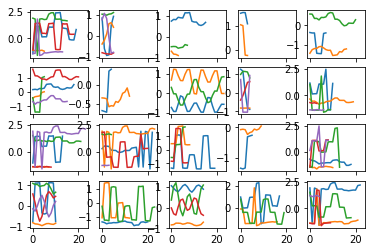

it		avg		std		max		time
1		-0.3585		0.069		-0.287236	10.9234
2		-0.2922		0.037		-0.255845	18.5339
3		-0.2589		0.054		-0.191447	24.805
4		-0.2407		0.052		-0.180382	19.5553
5		-0.2183		0.046		-0.170322	23.6019
6		-0.188		0.041		-0.142364	22.2028
7		-0.1991		0.027		-0.142364	28.5442
8		-0.1917		0.03		-0.142364	26.5828
9		-0.1694		0.025		-0.142364	28.5636
10		-0.1855		0.037		-0.138012	28.5279
11		-0.1749		0.034		-0.138012	30.1643
12		-0.1751		0.039		-0.134676	26.5267
13		-0.1673		0.032		-0.133559	29.5368
14		-0.1467		0.016		-0.133559	32.2751
15		-0.1543		0.026		-0.133559	27.8571
16		-0.1458		0.011		-0.131115	28.2646
17		-0.1403		0.007		-0.129245	29.9213
18		-0.1312		0.006		-0.125429	31.5544
19		-0.1192		0.009		-0.103279	32.5774


2019-05-24 02:51:12.383 | INFO     | tools.trajectory_generator:data_generation:623 - 
 Starting the generator with attributes: 
Original latitude: 37.295493
Original longitude: 23.824322
Initial bearing: 90
Initial speed: 10
Number of samples: 25
Starting time of measurements: 2015-02-01 12:00:00
With initial frequency of collected data: 3 min
and hard reset of data: True
2019-05-24 02:51:12.386 | INFO     | tools.trajectory_generator:data_generation:626 - Create directory 'generator_data' 
2019-05-24 02:51:12.389 | INFO     | tools.trajectory_generator:data_generation:632 - now creating data for movement: creeping_line_right


20		-0.1168		0.008		-0.103279	36.5732


2019-05-24 02:51:21.633 | INFO     | tools.trajectory_generator:data_generation:637 - now creating data for movement: random
2019-05-24 02:51:53.650 | SUCCESS  | tools.trajectory_generator:data_generation:670 - Done with generator
2019-05-24 02:51:53.652 | INFO     | tools.data_extraction:read_datasets:22 - Reading the data files
2019-05-24 02:51:54.390 | SUCCESS  | tools.data_extraction:read_datasets:51 - Done reading files
2019-05-24 02:51:55.450 | INFO     | tools.data_extraction:define_csv:76 - Creating x_train.csv--y_train.csv and x_test.csv--y_test.csv 
2019-05-24 02:51:55.478 | SUCCESS  | tools.data_extraction:define_csv:101 - Done with train.csv
2019-05-24 02:51:55.492 | INFO     | tools.data_extraction:define_csv:122 - Done with test.csv
2019-05-24 02:51:55.494 | INFO     | tools.data_extraction:load_datasets:129 - Loading the csv files to the appropriate train and test arrays(nparrays)
2019-05-24 02:51:55.513 | SUCCESS  | tools.data_extraction:load_datasets:134 - Done


The train samples length is:6000
The test samples length is:1500

standardized train and test data



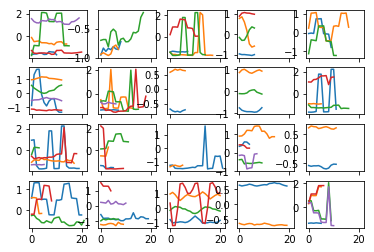

it		avg		std		max		time
1		-0.323		0.103		-0.171646	11.6935
2		-0.2992		0.078		-0.171646	15.438
3		-0.2558		0.058		-0.171646	16.315
4		-0.2501		0.074		-0.171646	14.2533
5		-0.2098		0.04		-0.170713	19.3927
6		-0.1854		0.022		-0.147432	17.5005
7		-0.1657		0.025		-0.124263	16.8161
8		-0.1315		0.025		-0.104677	14.3106
9		-0.1362		0.024		-0.104677	19.9069
10		-0.129		0.018		-0.104677	19.8927
11		-0.1204		0.023		-0.083621	19.1512
12		-0.1007		0.027		-0.07629	22.1642
13		-0.0882		0.016		-0.064269	17.2266
14		-0.0877		0.015		-0.064269	24.4483
15		-0.0892		0.015		-0.064269	26.1734
16		-0.0886		0.014		-0.064269	27.7488
17		-0.0847		0.01		-0.064269	24.6483
18		-0.0761		0.01		-0.064269	25.3964
19		-0.0729		0.011		-0.057214	21.804


2019-05-24 02:59:29.584 | INFO     | tools.trajectory_generator:data_generation:623 - 
 Starting the generator with attributes: 
Original latitude: 37.295493
Original longitude: 23.824322
Initial bearing: 90
Initial speed: 10
Number of samples: 25
Starting time of measurements: 2015-02-01 12:00:00
With initial frequency of collected data: 3 min
and hard reset of data: True
2019-05-24 02:59:29.586 | INFO     | tools.trajectory_generator:data_generation:626 - Create directory 'generator_data' 
2019-05-24 02:59:29.593 | INFO     | tools.trajectory_generator:data_generation:632 - now creating data for movement: sector_pattern_left


20		-0.0754		0.013		-0.057094	31.333


2019-05-24 02:59:32.766 | INFO     | tools.trajectory_generator:data_generation:637 - now creating data for movement: random
2019-05-24 03:00:04.599 | SUCCESS  | tools.trajectory_generator:data_generation:670 - Done with generator
2019-05-24 03:00:04.601 | INFO     | tools.data_extraction:read_datasets:22 - Reading the data files
2019-05-24 03:00:05.354 | SUCCESS  | tools.data_extraction:read_datasets:51 - Done reading files
2019-05-24 03:00:06.438 | INFO     | tools.data_extraction:define_csv:76 - Creating x_train.csv--y_train.csv and x_test.csv--y_test.csv 
2019-05-24 03:00:06.467 | SUCCESS  | tools.data_extraction:define_csv:101 - Done with train.csv
2019-05-24 03:00:06.477 | INFO     | tools.data_extraction:define_csv:122 - Done with test.csv
2019-05-24 03:00:06.478 | INFO     | tools.data_extraction:load_datasets:129 - Loading the csv files to the appropriate train and test arrays(nparrays)
2019-05-24 03:00:06.509 | SUCCESS  | tools.data_extraction:load_datasets:134 - Done


The train samples length is:6000
The test samples length is:1500

standardized train and test data



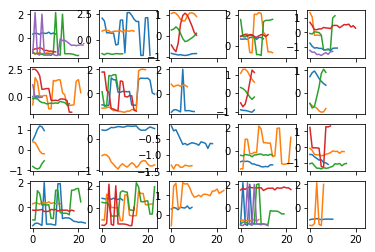

it		avg		std		max		time
1		-0.3067		0.103		-0.143986	10.0
2		-0.2841		0.116		-0.143986	11.5426
3		-0.2242		0.067		-0.143986	14.0674
4		-0.2643		0.076		-0.143986	12.3771
5		-0.2127		0.072		-0.143986	14.4352
6		-0.1686		0.047		-0.134014	14.1624
7		-0.1504		0.025		-0.115664	16.032
8		-0.1473		0.024		-0.115664	15.4163
9		-0.1424		0.021		-0.112452	13.8234
10		-0.1338		0.013		-0.112452	14.8129
11		-0.1349		0.02		-0.111401	13.7406
12		-0.1272		0.015		-0.111401	14.1174
13		-0.1165		0.007		-0.106181	17.7227
14		-0.1128		0.006		-0.10566	18.4636
15		-0.1014		0.006		-0.093357	19.7737
16		-0.1023		0.004		-0.093357	20.5695
17		-0.0966		0.008		-0.084106	22.0546
18		-0.0955		0.008		-0.083573	21.7028
19		-0.09		0.004		-0.083573	21.7892


2019-05-24 03:06:22.406 | INFO     | tools.trajectory_generator:data_generation:623 - 
 Starting the generator with attributes: 
Original latitude: 37.295493
Original longitude: 23.824322
Initial bearing: 90
Initial speed: 10
Number of samples: 25
Starting time of measurements: 2015-02-01 12:00:00
With initial frequency of collected data: 3 min
and hard reset of data: True
2019-05-24 03:06:22.408 | INFO     | tools.trajectory_generator:data_generation:626 - Create directory 'generator_data' 
2019-05-24 03:06:22.409 | INFO     | tools.trajectory_generator:data_generation:632 - now creating data for movement: sector_pattern_right


20		-0.089		0.006		-0.083101	24.0599


2019-05-24 03:06:25.629 | INFO     | tools.trajectory_generator:data_generation:637 - now creating data for movement: random
2019-05-24 03:06:57.874 | SUCCESS  | tools.trajectory_generator:data_generation:670 - Done with generator
2019-05-24 03:06:57.876 | INFO     | tools.data_extraction:read_datasets:22 - Reading the data files
2019-05-24 03:06:58.607 | SUCCESS  | tools.data_extraction:read_datasets:51 - Done reading files
2019-05-24 03:06:59.650 | INFO     | tools.data_extraction:define_csv:76 - Creating x_train.csv--y_train.csv and x_test.csv--y_test.csv 
2019-05-24 03:06:59.685 | SUCCESS  | tools.data_extraction:define_csv:101 - Done with train.csv
2019-05-24 03:06:59.696 | INFO     | tools.data_extraction:define_csv:122 - Done with test.csv
2019-05-24 03:06:59.699 | INFO     | tools.data_extraction:load_datasets:129 - Loading the csv files to the appropriate train and test arrays(nparrays)
2019-05-24 03:06:59.730 | SUCCESS  | tools.data_extraction:load_datasets:134 - Done


The train samples length is:6000
The test samples length is:1500

standardized train and test data



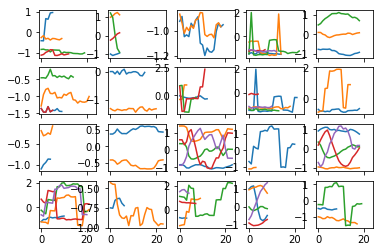

it		avg		std		max		time
1		-0.4067		0.105		-0.285129	10.3207
2		-0.3246		0.055		-0.285129	14.0337
3		-0.3344		0.078		-0.244714	14.2085
4		-0.3151		0.058		-0.244714	13.0336
5		-0.3029		0.037		-0.243996	12.4176
6		-0.2793		0.036		-0.176234	14.6416
7		-0.266		0.032		-0.176234	14.2926
8		-0.2351		0.054		-0.176234	22.1563
9		-0.2265		0.037		-0.176234	19.1814
10		-0.2384		0.027		-0.176234	22.4399
11		-0.2224		0.021		-0.176234	25.1343
12		-0.1988		0.014		-0.176234	23.3555
13		-0.1859		0.015		-0.163585	22.312
14		-0.1771		0.015		-0.151428	34.8397
15		-0.1753		0.01		-0.151428	34.0413
16		-0.1737		0.008		-0.151428	36.5102
17		-0.1634		0.01		-0.151428	35.4932
18		-0.1595		0.006		-0.145168	38.9589
19		-0.151		0.01		-0.133355	37.2081
20		-0.1371		0.009		-0.128317	38.47


In [3]:
for x in all_movements:
    set_movements(x)
    # Create files if not created
    tr_gen = TrajectoryGenerator(**tr_gen_options)
    tr_gen.data_generation(**dt_gen_options)
    # Read in the datafiles
    dex = DataExtractor()
    train_df, test_df = dex.train_test_dataframes(**train_test_options)
    print("The train samples length is:{0}".format(len(train_df[0] * train_test_options["split"]*2)))
    print("The test samples length is:{0}\n".format(len(test_df[0] * train_test_options["split"]*2)))
    dex.define_csv(**df_csvs_options)

    x_train, y_train, x_test, y_test = dex.load_datasets()
    print("standardized train and test data\n")
    x_train, x_test = standardize_data(x_train, x_test)
    genetic_extractor = GeneticExtractor(**genetic_options)
    print_genetic_param(genetic_extractor)
    genetic_extractor.fit(x_train, y_train)

    from sklearn.externals import joblib
    filename = "models/"+x["first_movement"][0]
    with open(filename+".pkl", 'wb') as pickle_file:
        joblib.dump(genetic_extractor, pickle_file)
        pickle_file.close()
    